<a href="https://colab.research.google.com/github/ebsenthil/langgraph-agent-class2/blob/main/langgraph_class_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
file='/content/drive/MyDrive/langgraph-data/usa.txt'

In [ ]:
with open(file, 'r') as file:
    print(file.read())


In [8]:
from google.colab import userdata

# Access the secret
tavily_api_key = userdata.get('TAVILY_API_KEY')
api_key = userdata.get('OPENAI_API_KEY')

# Print it (for verification during development, avoid in production logs)
#print(f"Tavily API Key (first 5 chars): {TAVILY_API_KEY[:5]}*****")


In [4]:
print("all ok")

all ok


In [6]:
!pip install langchain_tavily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 93.1 MB/s eta 0:00:00


In [76]:
from langchain_tavily import TavilySearch

tool = TavilySearch(
    max_results=5,
    topic="general",
    tavily_api_key=tavily_api_key,
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [77]:
result=tool.invoke({"query": "current news in chennai"})
result

{'query': 'current news in chennai',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Chennai News: Today's Latest & Breaking Chennai News Headlines - News18",
   'url': 'https://www.news18.com/cities/chennai-news/',
   'content': "Chennai News: Read today's Breaking and latest Chennai News headlines from News18, covering Chennai's politics, crime, education, business, and sports news updates.",
   'score': 0.7447496,
   'raw_content': None},
  {'title': "Chennai News: Today's Latest Chennai Top News Headlines ... - India Today",
   'url': 'https://www.indiatoday.in/cities/chennai-news',
   'content': 'Chennai News Today: Find the Latest and Breaking Chennai News Headlines, Chennai Crime News, Chennai Education News, Chennai Politics news and more on India Today.',
   'score': 0.7171114,
   'raw_content': None},
  {'title': 'Latest and Breaking Chennai News - NDTV.com',
   'url': 'https://www.ndtv.com/chennai-news/',
   'content': "Today's Chennai N

In [11]:
internet=[]
for item in result['results']:
  internet.append(item['content'])

In [ ]:
internet

In [13]:
internet="\n\n".join(internet)

In [ ]:
internet

In [4]:
from google.colab import userdata
# Access the secret
tavily_api_key = userdata.get('TAVILY_API_KEY')
openai_api_key = userdata.get('OPENAI_API_KEY')

# Print it (for verification during development, avoid in production logs)
#print(f"Tavily API Key (first 5 chars): {TAVILY_API_KEY[:5]}*****")
print(f"Openai API Key (first 10 chars): {openai_api_key[:10]}*****")

Openai API Key (first 10 chars): sk-proj-0m*****


In [ ]:
!pip install langchain_openai

In [5]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-3.5-turbo",api_key=openai_api_key)  # or "gpt-3.5-turbo"
output = model.invoke("hi")
print(output.content)

Hello! How can I assist you today?


In [6]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small",api_key=openai_api_key)  # or "text-embedding-ada-002"
vector = embeddings.embed_query("hi")
print(len(vector))

1536


In [ ]:
!pip install langchain_community

In [8]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [9]:
from langchain.document_loaders import TextLoader

# Load the single file directly
loader = TextLoader('/content/drive/MyDrive/langgraph-data/usa.txt')
docs = loader.load()

In [ ]:
docs[0].page_content

In [11]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [12]:
new_docs=text_splitter.split_documents(documents=docs)

In [ ]:
new_docs

In [14]:
doc_string=[doc.page_content for doc in new_docs]

In [ ]:
doc_string

In [ ]:
!pip install chromadb

In [18]:
db=Chroma.from_documents(new_docs,embeddings)

In [19]:
retriever=db.as_retriever(search_kwargs={"k": 3})

In [ ]:
retriever.invoke("industrial growth of usa?")

In [ ]:
!pip install langgraph

In [22]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

In [23]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [24]:
from langchain.output_parsers import PydanticOutputParser

In [25]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [26]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [27]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [28]:
state={"messages":["hi"]}

In [29]:
state="hi"

In [30]:
def function_1(state:AgentState):

    question=state["messages"][-1]

    print("Question",question)

    template="""
    Your task is to classify the given user query into one of the following categories: [USA,Temperature,Not Related].
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )


    chain= prompt | model | parser

    response = chain.invoke({"question":question})

    print("Parsed response:", response)

    return {"messages": [response.Topic]}

In [31]:
state={"messages":["what is a today temperature?"]}

In [34]:
state={"messages":["what is a temperature in chennai??"]}

In [35]:
function_1(state)

Question what is a temperature in chennai??
Parsed response: Topic='Temperature' Reasoning='The query is asking for the temperature in Chennai, which falls under the topic of Temperature.'


{'messages': ['Temperature']}

In [36]:
def router(state: AgentState):
    print("-> ROUTER ->")

    last_message = state["messages"][-1]
    print("last_message:", last_message)

    message_text = last_message.lower()

    if "temperature" in message_text:
        return "INTERNET Call"
    elif "usa" in message_text:
        return "RAG Call"
    else:
        return "LLM Call"


In [37]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [38]:
# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")

    question = state["messages"][0]

    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",

        input_variables=['context', 'question']
    )

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [39]:
# LLM Function
def function_3(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]

    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

In [91]:
# INTERNET Function
def function_4(state:AgentState):
    print("-> INTERNET Call ->")
    question = state["messages"][0]
    # Initialize tool inside function
    tool = TavilySearch(
        max_results=5,
        topic="general",
        tavily_api_key=tavily_api_key,
    )

    # INTERNET call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = tool.invoke({"query": complete_query})
    #return {"messages": [response.content]}
    content = str(response)
    return {"messages": [content]}

In [92]:
from langgraph.graph import StateGraph,END

In [93]:
workflow=StateGraph(AgentState)

In [94]:
workflow.add_node("Supervisor",function_1)

In [95]:
workflow.add_node("RAG",function_2)

In [96]:
workflow.add_node("LLM",function_3)

In [97]:
workflow.add_node("INTERNET",function_4)

In [98]:
workflow.set_entry_point("Supervisor")

In [99]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "INTERNET Call": "INTERNET",
    }
)

In [100]:
workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)
workflow.add_edge("INTERNET",END)

In [101]:
app=workflow.compile()

In [102]:
state={"messages":["how is ooty weather"]}

In [ ]:
app.invoke(state)

In [ ]:
state={"messages":["what is a gdp of usa?"]}

In [ ]:
app.invoke(state)

In [82]:
state={"messages":["can you tell me the industrial growth of world's most powerful economy?"]}

In [83]:
state={"messages":["can you tell me the industrial growth of world's poor economy?"]}

In [ ]:
result=app.invoke(state)

In [ ]:
result["messages"][-1]

In [114]:
from IPython.display import Image, display

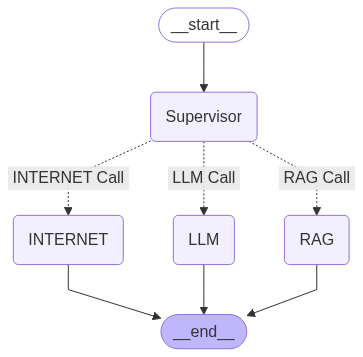

In [115]:
display(Image(app.get_graph().draw_mermaid_png()))